In [1]:
import numpy as np

from scipy.stats import norm
from tqdm import tqdm
import os

from Chempy.parameter import ModelParameters

import sbi.utils as utils

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

In [3]:
# ---  Load in the validation data ---
path_test = os.getcwd() + '/data/chempy_data/TNG_Test_Data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_theta = val_data['params']
val_x = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y

val_theta, val_x     = clean_data(val_theta, val_x)

# convert to torch tensors
val_theta = torch.tensor(val_theta, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)

In [4]:
# ----- Load posterior -----
with open('data/posterior_sbi_w5p-error_noH.pickle', 'rb') as f:
    posterior = pickle.load(f)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/export/home/bguenes/envs/master_chempy_multi/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

In [5]:
abundances =  torch.cat([val_x[:,:2], val_x[:,3:]], dim=1)

In [6]:
theta_hat = torch.zeros_like(val_theta)
for index in tqdm(range(len(abundances))):
    thetas_predicted = posterior.sample((1000,), x=abundances[index], show_progress_bars=False)
    theta_predicted = thetas_predicted.mean(dim=0)
    theta_hat[index] = theta_predicted

 97%|█████████▋| 44490/45771 [30:43<00:43, 29.77it/s]   WARNING:root:Only 0.494% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    -6 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
100%|██████████| 45771/45771 [31:27<00:00, 24.25it/s]


In [61]:
ape = torch.abs((val_theta - theta_hat) / val_theta) *100

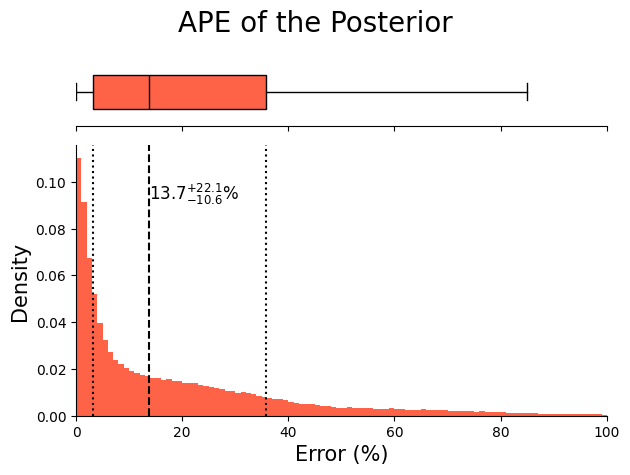

In [62]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

ax_hist.hist(ape.flatten(), bins=100, density=True, range=(0, 100), color='tomato')
ax_hist.set_xlabel('Error (%)', fontsize=15)
ax_hist.set_ylabel('Density', fontsize=15)
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
# percentiles
p1,p2,p3 = np.percentile(ape, [25, 50, 75])
ax_hist.axvline(p2, color='black', linestyle='--')
ax_hist.axvline(p1, color='black', linestyle='dotted')
ax_hist.axvline(p3, color='black', linestyle='dotted')
ax_hist.text(p2, 0.1, fr'${p2:.1f}^{{+{p3-p2:.1f}}}_{{-{p2-p1:.1f}}}\%$', fontsize=12, verticalalignment='top')

ax_box.boxplot(ape.flatten(), vert=False, autorange=False, widths=0.5, patch_artist=True, showfliers=False, boxprops=dict(facecolor='tomato'), medianprops=dict(color='black'))
ax_box.set(yticks=[])
ax_box.spines['left'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.spines['top'].set_visible(False)

fig.suptitle('APE of the Posterior', fontsize=20)
plt.xlim(0, 100)
fig.tight_layout()
plt.show()

In [64]:
torch.save(ape, 'data/ape_sbi_w5p-error_noH.pt')